In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')
sns.set_context('talk')

In [2]:
req_seq = pd.read_csv('./pop_mapping_web_3.csv', index_col=[0], header=0)
req_seq.head()

,Timestamp,Type,Offset,Size,fid
0,128166465299039421,Read,32256,8192,9
1,128166465299119535,Read,182082715136,4096,199
2,128166465299134409,Read,182082719232,4096,475
3,128166465299149505,Write,3221282304,4096,6
4,128166465299149970,Write,32256,8192,9


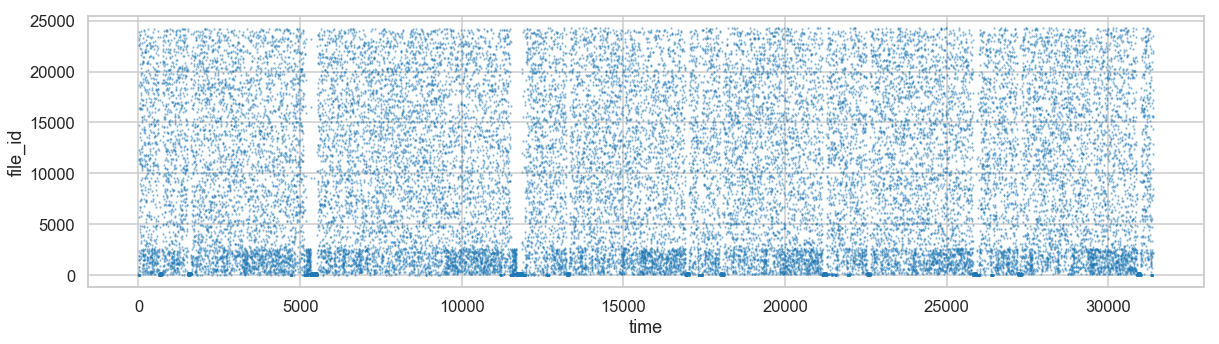

In [63]:
plt.figure(figsize=(20, 5))
plt.scatter(range(len(req_seq.fid)),list(req_seq.fid),s=1,marker='d',alpha=0.4)
plt.xlabel("time")
plt.ylabel("file_id")
plt.show()

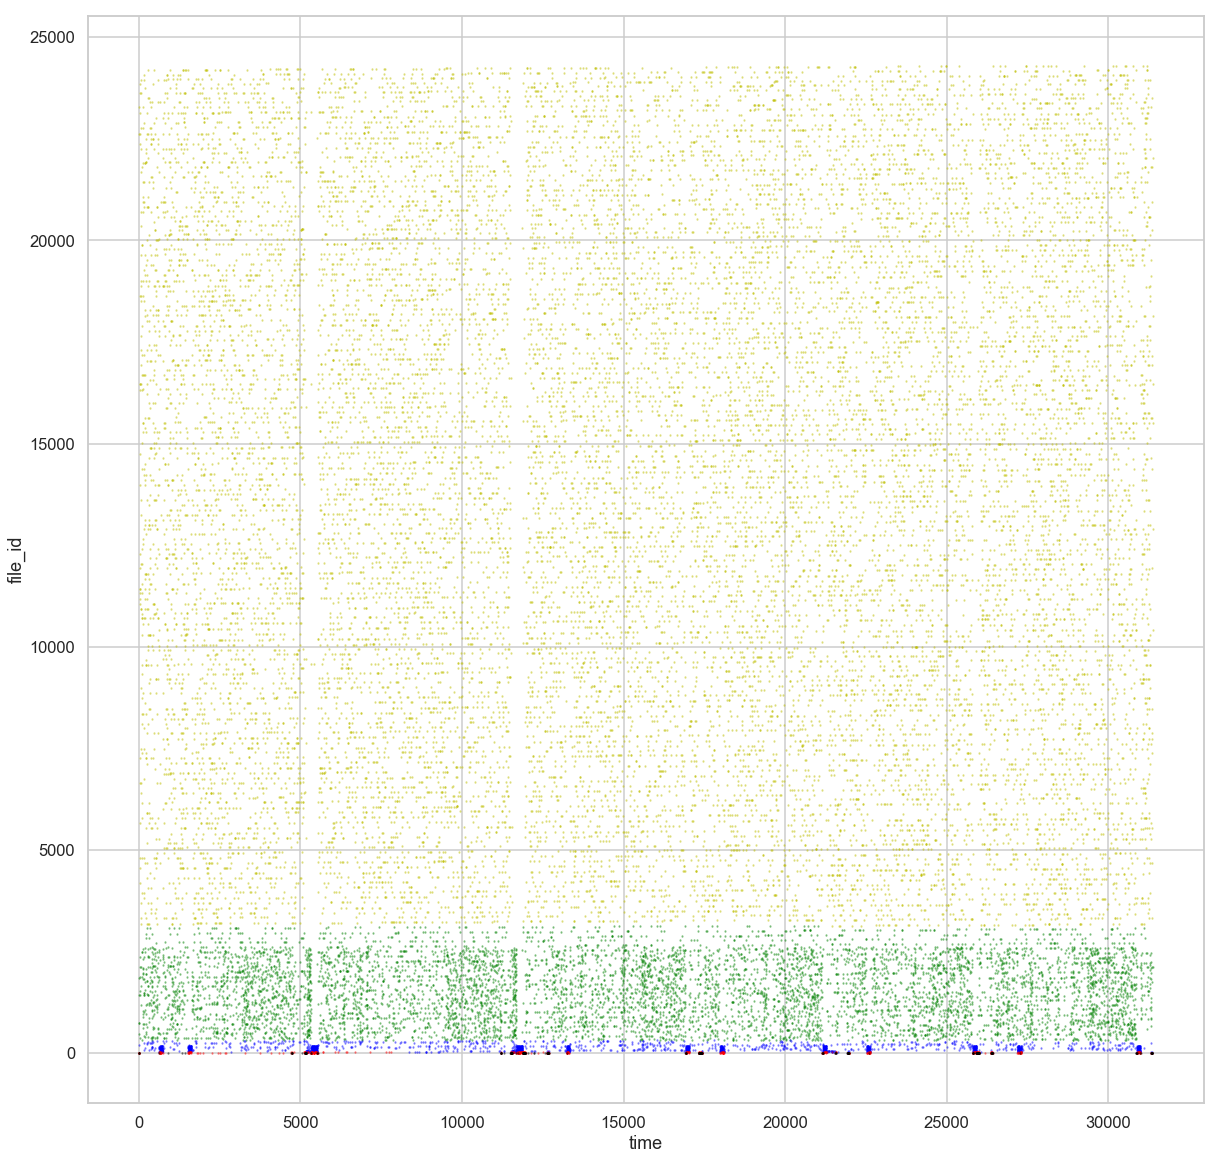

In [65]:
plt.figure(figsize=(20, 20))
i=trace_size=len(req_seq.fid)
colors=['y','g','b','r','black']
j=0
while i>=1:
    t=req_seq.fid[req_seq.fid<i][req_seq.fid>=i/10]
    plt.scatter(t.index,list(t),s=1,marker='d',color=colors[j],alpha=0.4)
    i=i/10
    j+=1
# t=req_seq.fid[req_seq.fid<100]
# plt.scatter(t.index,list(t),s=1,marker='d',color='b',label='fid<100')
# t=req_seq.fid[req_seq.fid>=100][req_seq.fid<1000]
# plt.scatter(t.index,list(t),s=1,marker='d',color='r',label='100<=fid<1000')
# t=req_seq.fid[req_seq.fid>=1000][req_seq.fid<10000]
# plt.scatter(t.index,list(t),s=1,marker='d',color='y',label='1000<=fid<10000')
plt.xlabel("time")
plt.ylabel("file_id")
# plt.legend()
plt.show()

In [66]:
trace_size

31380

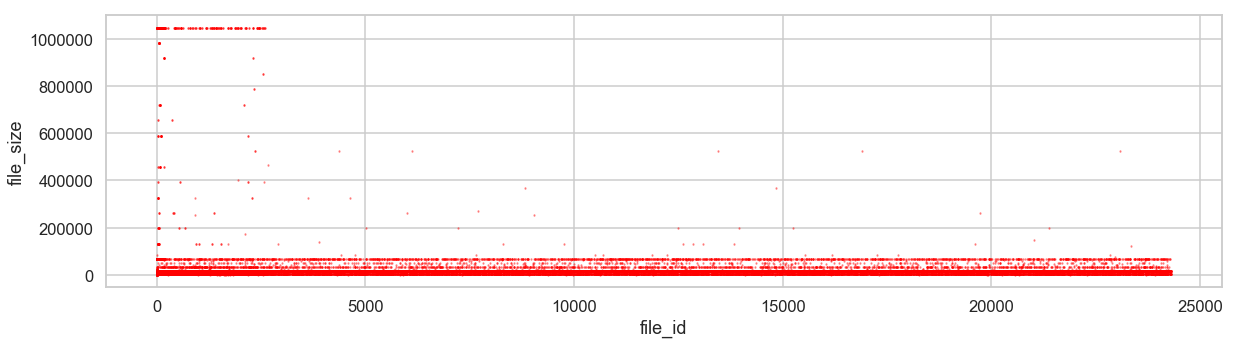

In [62]:
plt.figure(figsize=(20, 5))
plt.scatter(list(req_seq.fid),list(req_seq.Size),s=1,marker='d',color='r',alpha=0.4)
plt.xlabel("file_id")
plt.ylabel("file_size")
plt.show()

/Users/liyunfan/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


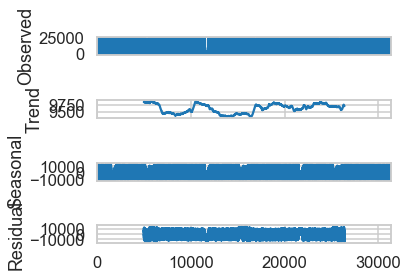

In [31]:
decompfreq=10000
res = sm.tsa.seasonal_decompose(req_seq.fid.interpolate(),
                                freq=decompfreq,
                                model='additive')
resplot = res.plot()
# resplot.savefig('Seasonal_Decompose.png', dpi=150)
resplot.show()

In [36]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [37]:
import pandas as pd
from rpy2.robjects import r, pandas2ri
import numpy as np
from rpy2.robjects.packages import importr


def decompose(series, frequency, s_window = 'periodic', log = False,  **kwargs):
    '''
    Decompose a time series into seasonal, trend and irregular components using loess, 
    acronym STL.
    https://www.rdocumentation.org/packages/stats/versions/3.4.3/topics/stl

    params:
        series: a time series

        frequency: the number of observations per “cycle” 
                   (normally a year, but sometimes a week, a day or an hour)
                   https://robjhyndman.com/hyndsight/seasonal-periods/

        s_window: either the character string "periodic" or the span 
                 (in lags) of the loess window for seasonal extraction, 
                 which should be odd and at least 7, according to Cleveland 
                 et al.

        log:    boolean.  take log of series



        **kwargs:  See other params for stl at 
           https://www.rdocumentation.org/packages/stats/versions/3.4.3/topics/stl
    '''

    df = pd.DataFrame()
    df['date'] = series.index
    if log: series = series.pipe(np.log)
    s = [x for x in series.values]
    length = len(series)
    s = r.ts(s, frequency=frequency)
    decomposed = [x for x in r.stl(s, s_window).rx2('time.series')]
    df['observed'] = series.values
    df['trend'] = decomposed[length:2*length]
    df['seasonal'] = decomposed[0:length]
    df['residuals'] = decomposed[2*length:3*length]
    return df

In [41]:
obs_per_cycle = 52
observations = obs_per_cycle * 3
# data = [v+2*i for i,v in enumerate(np.random.normal(5, 1, observations))]
# tidx = pd.date_range('2016-07-01', periods=observations, freq='w')
# ts = pd.Series(data=data, index=tidx)
ts = req_seq.fid[req_seq.fid<100]
df = decompose(ts, frequency=obs_per_cycle, s_window = 'periodic')

In [42]:
df.head()

,date,observed,trend,seasonal,residuals
0,0,9,8.031132,-5.564365,6.533232
1,3,6,8.910742,-2.131513,-0.779230
2,4,9,9.790352,-2.398661,1.608308
3,5,5,10.669963,0.067525,-5.737487
4,7,1,11.549573,1.967043,-12.516616


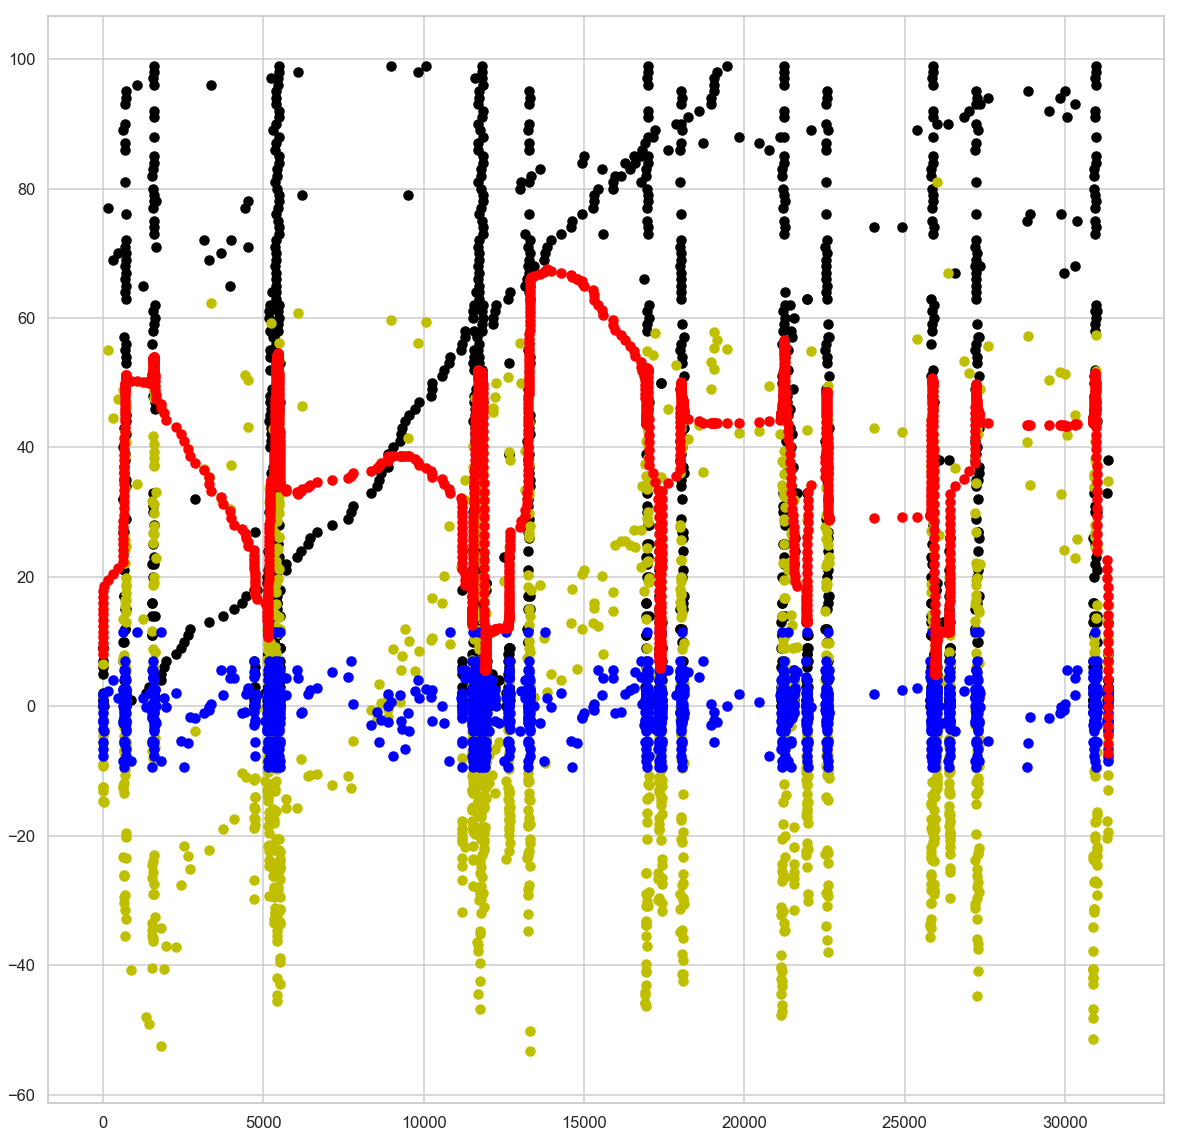

In [71]:
plt.figure(figsize=(20, 20))
# df.plot(kind='line',x='date',y='observed',color='black')
# df.plot(kind='line',x='date',y='trend',color='red')
# df.plot(kind='line',x='date',y='seasonal',color='green')
# df.plot(kind='line',x='date',y='residuals',color='yellow')

plt.scatter(df.date,df.observed,color='black')
plt.scatter(df.date,df.residuals,color='y')
plt.scatter(df.date,df.seasonal,color='b')
plt.scatter(df.date,df.trend,color='r')
plt.show()

In [73]:
print(np.mean(df.observed),
np.mean(df.trend),
np.mean(df.seasonal),
np.mean(df.residuals))

35.22926192031352 35.07186362549084 -0.0193275870378994 0.17672588186058477


In [75]:
req_seq.Timestamp=(req_seq.Timestamp/100).astype('int')
req_seq.Timestamp=req_seq.Timestamp-start_time
start_time,end_time=min(req_seq.Timestamp),max(req_seq.Timestamp)
start_time,end_time

(0, 59437622197)

In [76]:
time_range=range(start_time,end_time+1)
print(start_time,end_time,len(time_range))
# for file in req_seq.fid:
#     file_df=req_seq[req_seq.fid==file].drop('Type','Size','Offset')
#     ts=pd.Series(file_df.values)

0 59437622197 59437622198


In [ ]:
ts = req_seq.fid[req_seq.fid==0]-0+1
print(ts)
ts=ts.reindex(time_range).fillna(0)
sum(ts)

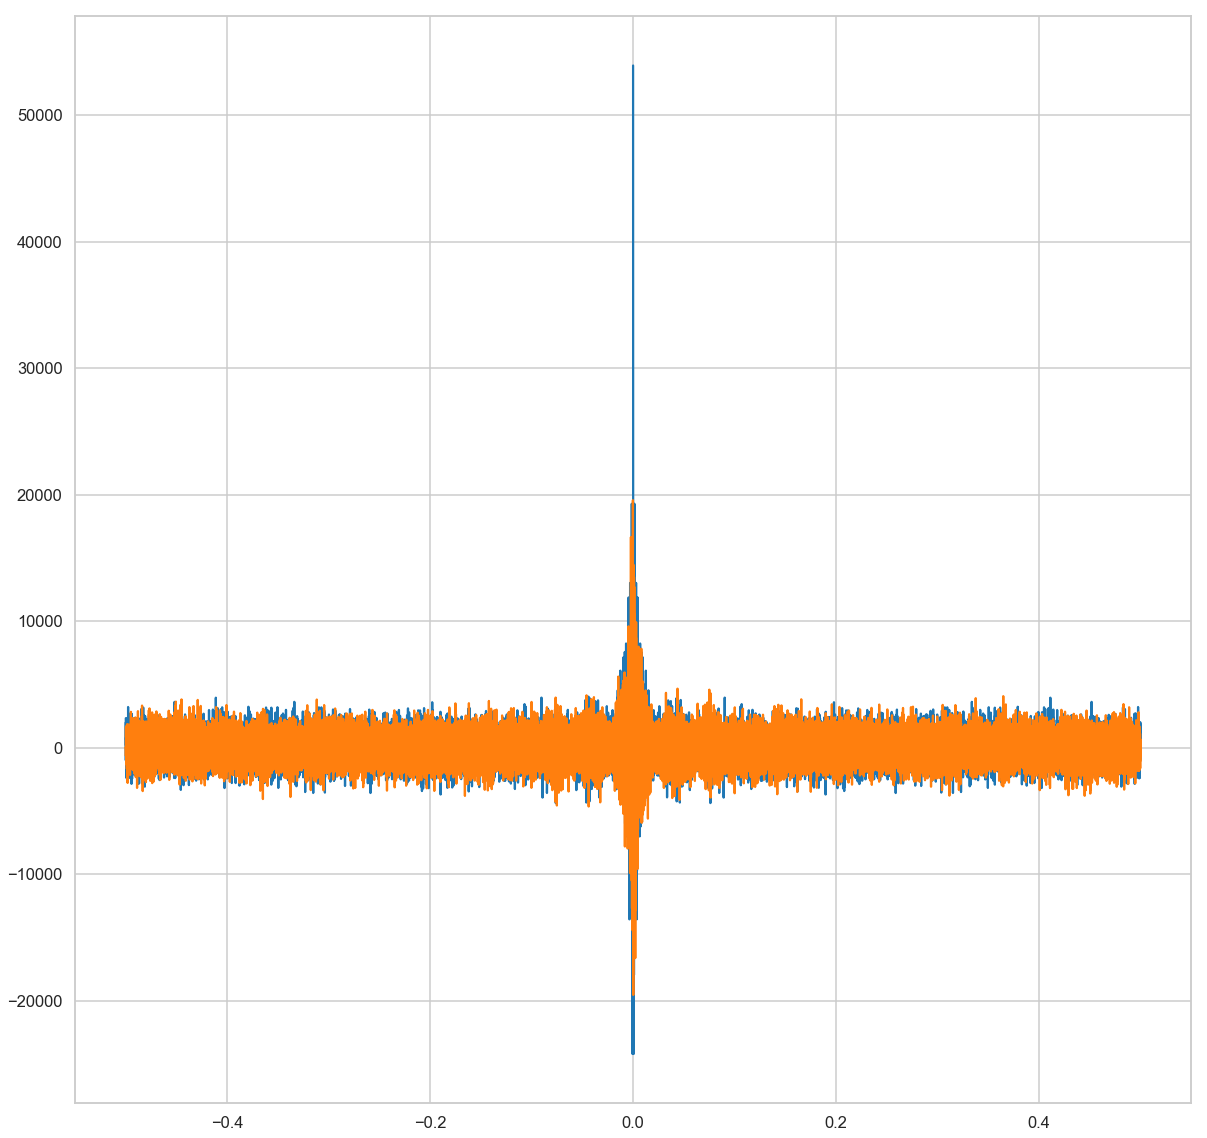

In [30]:
plt.figure(figsize=(20, 20))
res=np.fft.fft(ts)
freq = np.fft.fftfreq(ts.shape[-1])
plt.plot(freq, res.real, freq, res.imag)
plt.show()

In [33]:
pd.DataFrame(res,freq)

,0
0.000000,(53936+0j)
0.000032,(-2957.6748863866596-776.3473470685657j)
0.000064,(4631.034527436377+143.32157264646372j)
0.000096,(1281.4417629155305-5721.200824784065j)
0.000128,(-7446.61421080024+2287.0104184640786j)
0.000159,(11680.353246412893+5175.212066841917j)
0.000191,(11429.641003934095-19562.043138318877j)
0.000223,(12418.001537054151+3863.485683398965j)
0.000255,(-5607.730249962298-5052.407776436464j)
0.000287,(-8677.721348049421-3159.376641367161j)


/Users/liyunfan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


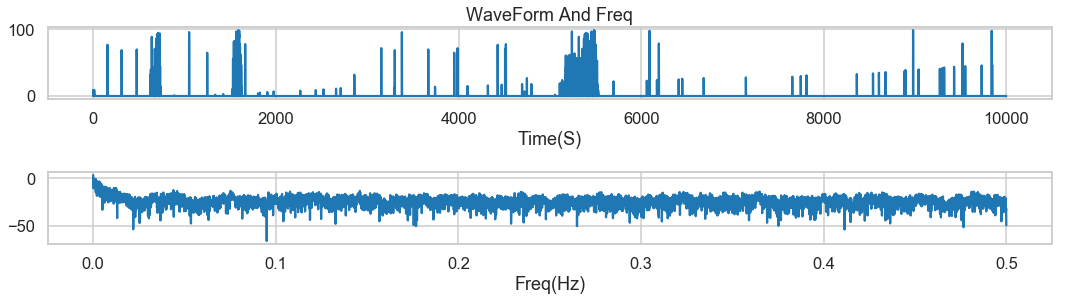

In [57]:
import numpy as np#导入一个数据处理模块
import pylab as pl#导入一个绘图模块，matplotlib下的模块

sampling_rate = 1#采样频率
fft_size = 10000 #FFT处理的取样长度
t = ts.index
x = list(ts)
# N点FFT进行精确频谱分析的要求是N个取样点包含整数个取样对象的波形。因此N点FFT能够完美计算频谱对取样对象的要求是n*Fs/N（n*采样频率/FFT长度），
# 因此对8KHZ和512点而言，完美采样对象的周期最小要求是8000/512=15.625HZ,所以156.25的n为10,234.375的n为15。
xs = x[:fft_size]# 从波形数据中取样fft_size个点进行运算
xf = np.fft.rfft(xs)/fft_size# 利用np.fft.rfft()进行FFT计算，rfft()是为了更方便对实数信号进行变换，由公式可知/fft_size为了正确显示波形能量
# rfft函数的返回值是N/2+1个复数，分别表示从0(Hz)到sampling_rate/2(Hz)的分。
#于是可以通过下面的np.linspace计算出返回值中每个下标对应的真正的频率：
freqs = np.linspace(0, sampling_rate/2, fft_size/2+1)
# np.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None)
#在指定的间隔内返回均匀间隔的数字
xfp = 20*np.log10(np.clip(np.abs(xf), 1e-20, 1e100))
#最后我们计算每个频率分量的幅值，并通过 20*np.log10()将其转换为以db单位的值。为了防止0幅值的成分造成log10无法计算，我们调用np.clip对xf的幅值进行上下限处理

#绘图显示结果
pl.figure(figsize=(18,4))
pl.subplot(211)
pl.plot(t[:fft_size], xs)
pl.xlabel(u"Time(S)")
pl.title(u"WaveForm And Freq")
pl.subplot(212)
pl.plot(freqs, xfp)
pl.xlabel(u"Freq(Hz)")
pl.subplots_adjust(hspace=1)
pl.show()

In [52]:
a = pd.DataFrame(req_seq.fid[req_seq.fid==1])
# pd.Series.to_frame(series)
a['id'] = list(a.index)
a

,fid,id
7,1,7
9,1,9
14,1,14
638,1,638
889,1,889
4719,1,4719
4727,1,4727
5132,1,5132
5137,1,5137
5150,1,5150


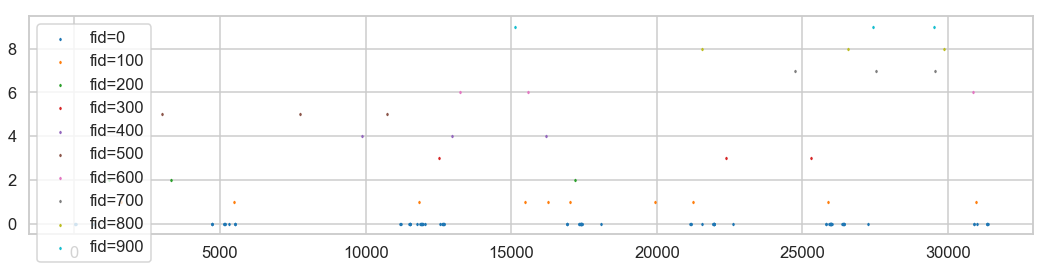

In [8]:
plt.figure(figsize=(18,4))
for i in range(0,1000,100):
    a = pd.DataFrame(req_seq.fid[req_seq.fid==i])
    plt.scatter(a.index,np.zeros(len(a))+0.01*i,s=2,marker='d',label='fid='+str(i))
plt.legend()
plt.show()

In [6]:
list(req_seq.Timestamp[req_seq.fid==0])

[128166465299150651,
 128166465299150709,
 128166465384617755,
 128166480064367075,
 128166520678952196,
 128166520708795941,
 128166520858795079,
 128166952944988517,
 128166953043427756,
 128166953193895532,
 128166953643111396,
 128167344080021619,
 128167391210658697,
 128167391210659165,
 128167391223315362,
 128167474707156044,
 128167474850748917,
 128168098226534752,
 128168098268565681,
 128168098419346049,
 128168098519657838,
 128168099071060643,
 128168208121530646,
 128168263260242744,
 128168263461022806,
 128168264192580648,
 128168294052233250,
 128168312575708421,
 128168312776800912,
 128168312876487745,
 128168313076642718,
 128168681534890372,
 128168681735826600,
 128168681752075034,
 128168681836294738,
 128168682286915994,
 128168682436915874,
 128169056375056922,
 128169056375056945,
 128169092091077612,
 128169092107796978,
 128169092307951961,
 128169541297232822,
 128169541400206346,
 128169541650842531,
 128169541850851510,
 128169589465730347,
 128169589586

In [ ]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import pywt
from matplotlib.font_manager import FontProperties

chinese_font = FontProperties(fname='/System/Library/Fonts/STHeiti Light.ttc')

In [ ]:
sampling_rate = 1024
t = np.arange(0, 1.0, 1.0 / sampling_rate)
f1 = 100
f2 = 200
f3 = 300
data = np.piecewise(t, [t < 1, t < 0.8, t < 0.3],
                    [lambda t: np.sin(2 * np.pi * f1 * t), lambda t: np.sin(2 * np.pi * f2 * t),
                     lambda t: np.sin(2 * np.pi * f3 * t)])
wavename = 'cgau8'
totalscal = 256

In [64]:
data

array([ 0.        ,  0.96377607, -0.51410274, ..., -0.96377607,
       -0.94154407, -0.57580819])

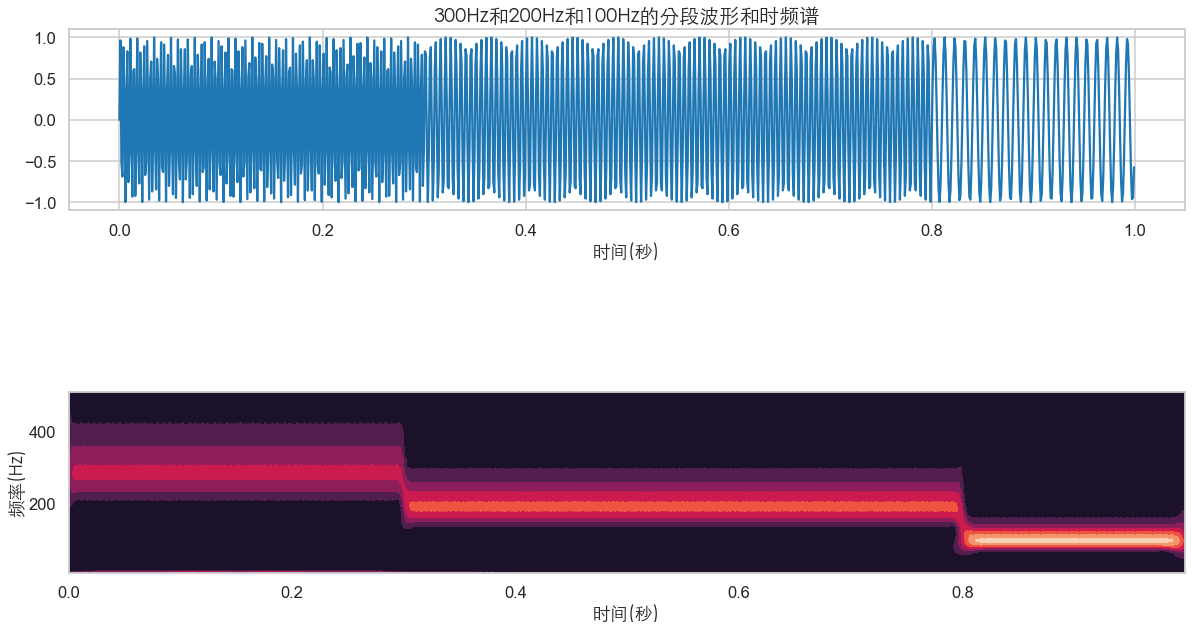

In [63]:
fc = pywt.central_frequency(wavename)
cparam = 2 * fc * totalscal
scales = cparam / np.arange(totalscal, 1, -1)
[cwtmatr, frequencies] = pywt.cwt(data, scales, wavename, 1.0 / sampling_rate)
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(t, data)
plt.xlabel(u"时间(秒)", fontproperties=chinese_font)
plt.title(u"300Hz和200Hz和100Hz的分段波形和时频谱", fontproperties=chinese_font, fontsize=20)
plt.subplot(212)
plt.contourf(t, frequencies, abs(cwtmatr))
plt.ylabel(u"频率(Hz)", fontproperties=chinese_font)
plt.xlabel(u"时间(秒)", fontproperties=chinese_font)
plt.subplots_adjust(hspace=1)
plt.show()